# REINFORCE with Dirichlet Policy

Following on from the work done in the pg_theory notebook we will now implement a Dirichlet policy and investigate the effect of different parameters on learning. We will then move on to look at how we can improve learning via the use of natural gradients.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'retro', 'grid'])
import pandas as pd

import sys
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [2]:
from scipy.stats import norm, beta, dirichlet
from scipy.special import gamma, digamma, polygamma, gammaln

from collections import defaultdict
from joblib import Parallel, delayed
from tqdm import tqdm 

We use a generative environment for the following experiments where returns are sampled from a multivariate Gaussian.

In [3]:
class GenerativeMarketEnv():

    def __init__(self, μ, Σ):
        self.μ = μ
        self.Σ = Σ
        self.best = np.argmax(μ)

    def reset(self):
        pass

    def step(self, weights):
        returns = np.random.multivariate_normal(self.μ, self.Σ)
        R = returns@weights
        return R, returns, returns[self.best]

We implement a Dirichlet policy with the following update.

$$\theta_{t+1} = \theta_{t} + \alpha G_t \left[ \psi \left(\sum_{n=1}^{N} a_n(s,\theta) \right) -  \sum_{n=1}^{N} \psi (a_n(s,\theta)) + \sum_{n=1}^{N}   \ln w_n \right]^T x(s)$$

The following class contains an implementation of a Dirichlet policy with natural gradients. We will build-up to this level of complexity throughout the notebook.

In [4]:
class DirichletPolicy:
    
    def __init__(
        self, n_assets, α=0.001, α_end=0.0001, start_ep=1000, 
        α_decay_steps=1000, γ=0.9, grad_adpt_mode='poly', 
        returns_adpt_mode='both',parameterisation='linear'
    ):
        self.n_assets = n_assets
        self.θ = np.ones(self.n_assets)
        self.α = α
        self.α_start = α
        self.α_end = α_end
        
        self.ep = 0
        self.start_ep = start_ep
        self.α_decay_steps = α_decay_steps
            
        
        self.γ = γ
        self.a_min = 1e-10
        self.a_max = 5
        self._grad_adpt_mode = grad_adpt_mode
        self._returns_adpt_mode = returns_adpt_mode
        self._parameterisation = parameterisation
        
    
    def act(self, X):
        a_n = self._calc_an(X)
        w_n = dirichlet.rvs(a_n)
        return w_n[0], a_n
        
        
    def grad(self, X, w):
        w[w <= 0] = 1e-10
        a_n = self._calc_an(X)
        g = (digamma(np.sum(a_n)) - digamma(a_n) + np.log(w)).T
        
        if self._parameterisation == 'linear':
             g = g @ X
        elif self._parameterisation == 'exp':
            g = g * np.exp(a_n) @ X
        elif self._parameterisation == 'softplus':
            g = g * (1/(1+np.exp(a_n))) @ X

        apt_g = self._adapt_grad(g, a_n)        
        return apt_g
    
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.γ + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards
    
    def update(self, Xs, ws, rs):
        self.ep += 1
        self.α = self._decay_epsilon()
        grads = [self.grad(*args) for args in zip(Xs, ws)]
        G = self.discount_rewards(rs)
        adpt_G = self._adapt_returns(rs, G)
        for grad, Gt in zip(grads, adpt_G):
            self.θ += self.α*(Gt)*grad
            
    def reset(self):
        self.θ = np.ones(self.n_assets)
        
    def _decay_epsilon(self):
        alpha = self.α_end + (self.α_start - self.α_end) * \
                   np.exp(-1. * ((self.ep - self.start_ep) / self.α_decay_steps))
        return min(alpha, self.α_start)
            
    def _calc_an(self, X):
        if self._parameterisation == 'linear':
            a_n = X@self.θ
            a_n[a_n < self.a_min] = self.a_min
            a_n[a_n > self.a_max] = self.a_max
            return a_n
        elif self._parameterisation == 'exp':
            return np.exp(X@self.θ)
        elif self._parameterisation == 'softplus':
            return np.log((1+1e-10) + np.exp(X@self.θ))
        else:
            raise ValueError('Invalid value for parameterisation.')
            
        
            
    def _adapt_grad(self, g, a_n):
        scale = 1
        if self._grad_adpt_mode == 'max_digamma':
            scale = max(abs(digamma(a_n)))
        elif self._grad_adpt_mode == 'max_polygamma':
            scale = max(abs(polygamma(1, a_n)))
        elif self._grad_adpt_mode == 'max_di_polly_interpolation':
            scale_α = max(abs(digamma(a_n)))
            scale_β = max(abs(polygamma(1, a_n)))
            scale = .5*scale_α + .5*scale_β
        elif self._grad_adpt_mode == 'natural_gradient':
            F = np.diag(polygamma(1, a_n)) -  polygamma(1, np.sum(a_n))*np.ones((self.n_assets,self.n_assets))
            F_inv = np.linalg.inv(F)
            return F_inv@g
        elif not self._grad_adpt_mode:
            return g
        else:
            raise ValueError('Invalid value for returns_adpt_mode.')
            
        return g/scale
    
    def _adapt_returns(self, rs, G):
        b = np.mean(rs)
        σ = np.mean(rs)
        if self._returns_adpt_mode == 'avg_r_baseline':
            return G-b
        elif self._returns_adpt_mode == 'noise_whitening':
            return G/(σ + 10e-10)
        elif self._returns_adpt_mode == 'both':
            return (G-b)/(σ + 10e-10)
        else:
            return G
        
            
        

A simple harness that given a policy and an environment can train the model and make useful plots.

In [5]:
class Harness:
    
    def __init__(self, env, policy, n_eps=50):
        self._env = env
        self._policy = policy
        self._n_eps = n_eps
        self._optimal_val = max(env.μ)*n_eps
        
        self.hist = {
            'states': [],
            'rewards': [],          
            'ep_rewards': [],
            'best_ep_rewards': [],
            'ws': [],
            'a_ns': [],
            'γ': policy.γ,
            'α': policy.α,
            'param': policy._parameterisation,
            'grad_adpt_mode': policy._grad_adpt_mode
            
        }
    
    def _generate_episode(self):
        state = self._env.reset()
        
        ep_reward = 0
        best_ep_reward = 0
        ws = []
        rewards = []
        states = []
        
        for i in range(self._n_eps):
            
    
            X = np.eye(self._policy.n_assets)
            w, a = self._policy.act(X)
    
            
            R, rs, best_r = self._env.step(w)      
            
            ep_reward += R
            best_ep_reward += best_r
            rewards.append(R)
            states.append(X)
            ws.append(w)
            
        self.hist['states'].append(states)
        self.hist['rewards'].append(rewards)
        self.hist['ws'].append(ws)
        self.hist['a_ns'].append(a)
        self.hist['ep_rewards'].append(ep_reward)
        self.hist['best_ep_rewards'].append(best_ep_reward)
        
        return np.array(states), np.array(rewards)
    
    def train(self, num_episodes=1000):
        self._policy.reset()
 
        for i in range(num_episodes):

            # run a single episode
            self._generate_episode()

            # update policy
            self._policy.update(self.hist['states'][i], self.hist['ws'][i], self.hist['rewards'][i])

    
    
    def plot_smooth_rewards(self, eps, window=10):
        rs = np.array(pd.Series(self.hist['ep_rewards']).rolling(window).mean()[window - 1:])
        plt.figure(figsize=(8, 6), dpi=100)
        plt.plot(np.arange(eps-(window-1)), rs)
        plt.ylabel('Total Returns')
        plt.xlabel('Episode')
#         plt.plot(np.arange(eps), self.hist['best_ep_rewards'])
        plt.hlines(self._optimal_val, 0, eps-(window-1), linestyles='dashed', colors='red')
        
    def plot_weights_vs_ep(self, eps):
        av_weights = np.array(self.hist['ws']).mean(axis=1)
        wn_over_time = list(zip(*av_weights))
        plt.figure(figsize=(8, 6), dpi=100)
        plt.plot(wn_over_time[0], label='Asset 1 weighting')
        plt.plot(wn_over_time[1], label='Asset 2 weighting')
        plt.plot(wn_over_time[2], label='Asset 3 weighting')
        plt.title('Average Weighting For Each Episode')
        plt.xlabel('Episode')
        plt.ylabel('Asset Weighting')
        plt.legend()
        
    def plot_episode_weights(self, ep):
        final_weights = list(zip(*np.array(self.hist['ws'])[ep-1][3:]))
        plt.figure(figsize=(8, 6), dpi=100)
        plt.plot(final_weights[0], linewidth=1.5, label='Asset 1 weighting')
        plt.plot(final_weights[1], linewidth=1.5, label='Asset 2 weighting')
        plt.plot(final_weights[2], linewidth=1.5, label='Asset 3 weighting')
        plt.title('Final Episode Weights')
        plt.xlabel('Time Step')
        plt.ylabel('Asset Weighting');
        plt.legend()

Class that create many harnesses and train models in parallel.

In [6]:
class ParallelRunner:
    
    def __init__(self, n_runs, params, legend_labels):
        self._n_runs = n_runs
        self._params = params
        self._legend_labels = legend_labels
        self.results = defaultdict(list)
        
    def run(self):
        arr = []
        for i, param in tqdm(enumerate(self._params)):
            rs = Parallel(n_jobs=10, backend='loky')(delayed(self.single_run)(param) for i in tqdm(range(self._n_runs)))
            arr.append(rs)
        for i, r in enumerate(arr):
            self.results[str(i)] = r
             
        
    def single_run(self, params):
        e = GenerativeMarketEnv([1, 3, 1], [[.1, 0, 0], [0, .1, 0], [0, 0, .1]])
        p = DirichletPolicy(*list(params.values())[:-1])
        h = Harness(e, p)
        h.train(num_episodes=params['eps'])
    
        return h.hist
    
    def plot_av_reward_for_run(self, key):
        
        ep_rewards  = []
        plt.figure(figsize=(8, 6), dpi=100)
        for r in self.results[key]:
            ep_rewards.append(r['ep_rewards'])
        ep_rewards = np.array(ep_rewards)
        
        plt.figure(figsize=(8, 6), dpi=100)
        mean = ep_rewards.mean(axis=0)
        std  = ep_rewards.std(axis=0)
        
        
        plt.plot(np.arange(ep_rewards.shape[1]), mean)
        plt.hlines(150, 0, ep_rewards.shape[1], linestyles='dashed', colors='red')
        plt.fill_between(np.arange(ep_rewards.shape[1]), mean - std, mean + std, alpha=0.6)
        
    def plot_av_rewards(self, window=1, file_name=None):
        plt.figure(figsize=(8, 6), dpi=100)
        for key in self.results:
            ep_rewards  = []
            for r in self.results[key]:
                ep_rewards.append(r['ep_rewards'])
            ep_rewards = np.array(ep_rewards)
            
            
            mean = ep_rewards.mean(axis=0)
            std  = ep_rewards.std(axis=0)
            
            smooth_mean = np.array(pd.Series(mean).rolling(window).mean()[window - 1:])
            
            plt.plot(np.arange(ep_rewards.shape[1] - (window-1)), smooth_mean, label=self._legend_labels[key])
            plt.fill_between(np.arange(ep_rewards.shape[1]), mean - std, mean + std, alpha=0.6)
        
        plt.legend()
        plt.xlabel('Episode')
        plt.ylabel('Total Returns')
        plt.hlines(150, 0, ep_rewards.shape[1], linestyles='dashed', colors='red')
        if file_name:
            plt.savefig('./report_images/{}'.format(file_name))

# Experiments 

During these initial experiments, the environment is a simple 3-dimensional Gaussian with a clear best asset where we try to optimise for raw rewards. This is done for illustrative purposes and we explore more realistic environments and try to optimise for more interesting rewards in subsequent notebooks.


## Investigating the Effect of gamma.

### Confounding effect of high variance policy

In order to ensure sufficient exploration early on we initialise the parameterization weights of the Dirichlet concentration parameters such that $a_0 = [1, 1, 1]$, when we extend this to more asset classes the vectors of concentration parameters will remain one. If we were to choose any other initialisation then we would bias the solution due to assigning high probability's densities to certain areas of the simplex. Although ensuring exploration at the start and avoiding initialisation bias the approach does suffer from high variance in the action selection which is especially problematic for vanilla REINFORCE that considers the full Monte Carlo returns. To see how this is problematic its instructive to visualise the weights for the first episode.

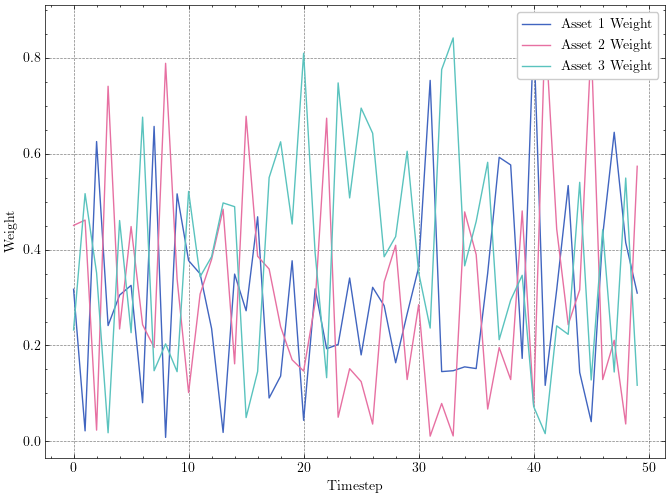

In [3]:
ws = list(zip(*dirichlet([1,1,1]).rvs(50)))

plt.figure(figsize=(8, 6), dpi=100)

plt.xlabel('Timestep')
plt.ylabel('Weight')
plt.plot(ws[0], label='Asset 1 Weight')
plt.plot(ws[1], label='Asset 2 Weight')
plt.plot(ws[2], label='Asset 3 Weight')
plt.legend(loc=1)
    
plt.savefig('./report_images/initial_weights')

We see that for the entirety of the first episode asset allocation will be high variance. On closer inspection of the definition for episodic returns, we can see how this is problematic. Recall that for REINFORCE an agent attempts to select actions such that the sum of the future rewards is maximised where discounted future rewards is given by

\begin{equation}
    G_t \dot{=} R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots
\end{equation}

when our agent is simply trying to maximise returns then the reward $R_i$ is the simple weighted sum where weights are drawn from the Dirichlet distribution. For $\gamma=1$ our agent considers all future rewards equally resulting in a confounding effect where large fluctuations in weight allocation make it difficult to learn the merit of immediate actions. By lowering $\gamma$ we can reduce this effect of confounding future actions.


**Idea: Start agent off as very myopic and as the Dirichlet distribution becomes more deterministic make the agent more long sighted**

In [26]:
μ = np.array([1, 3, 1])

Σ = np.array([[.1, 0, 0], [0, .1, 0], [0, 0, .1] ])

In [137]:
params_1 = {
    'n_assets': 3,
    'α': 0.8e-5,
    'α_end': 0.8e-5,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 1,
    'grad_adpt_mode': None,
    'returns_adpt_mode': None,
    'parameterisation': 'linear',
    'eps': 2000
}

params_2 = {
    'n_assets': 3,
    'α': 1.6e-5,
    'α_end': 1.6e-5,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.8,
    'grad_adpt_mode': None,
    'returns_adpt_mode': None,
    'parameterisation': 'linear',
    'eps': 2000
}


params_3 = {
    'n_assets': 3,
    'α': 1.8e-5,
    'α_end': 1.8e-5,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': None,
    'returns_adpt_mode': None,
    'parameterisation': 'linear',
    'eps': 2000
}

legend_labels = {
    '0': r'$\gamma$: 1, $\alpha$: 0.8e-5', 
    '1': r'$\gamma$: 0.8, $\alpha$: 1.6e-5',
    '2': r'$\gamma$: 0.6, $\alpha$: 1.8e-5',
}

params = [params_1, params_2, params_3]

0it [00:00, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 3871.96it/s]
1it [00:27, 27.49s/it]
100%|██████████| 4/4 [00:00<00:00, 3401.02it/s]
2it [00:55, 27.76s/it]
100%|██████████| 4/4 [00:00<00:00, 3659.15it/s]
3it [01:24, 28.14s/it]


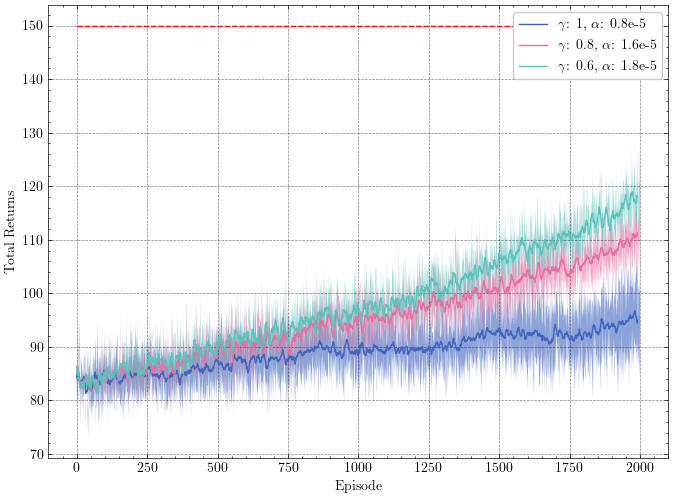

In [139]:
p_runner = ParallelRunner(4, params, legend_labels)
p_runner.run()
p_runner.plot_av_rewards(window=10, file_name='linear_vary_gamma')

## Investigating the Effect of Parameterisation.

Now we look at different parameterisations of the concentration parameters.

- Linear
- Softplus
- Exponential

In [157]:
params_1 = {
    'n_assets': 3,
    'α': 1.8e-5,
    'α_end': 1.8e-5,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': None,
    'returns_adpt_mode': None,
    'parameterisation': 'linear',
    'eps': 2000
}

params_2 = {
    'n_assets': 3,
    'α': 2.2e-4,
    'α_end': 2.2e-4,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': None,
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 2000
}

params_3 = {
    'n_assets': 3,
    'α': 1e-6,
    'α_end': 1e-6,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': None,
    'returns_adpt_mode': None,
    'parameterisation': 'exp',
    'eps': 2000
}


legend_labels = {
    '0': r'linear', 
    '1': r'softplus',
    '2': r'exp',
}

params = [params_1, params_2, params_3]

0it [00:00, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 1505.36it/s]
1it [00:26, 26.04s/it]
100%|██████████| 4/4 [00:00<00:00, 4000.29it/s]
2it [00:57, 27.55s/it]
100%|██████████| 4/4 [00:00<00:00, 4086.02it/s]
3it [01:22, 27.66s/it]


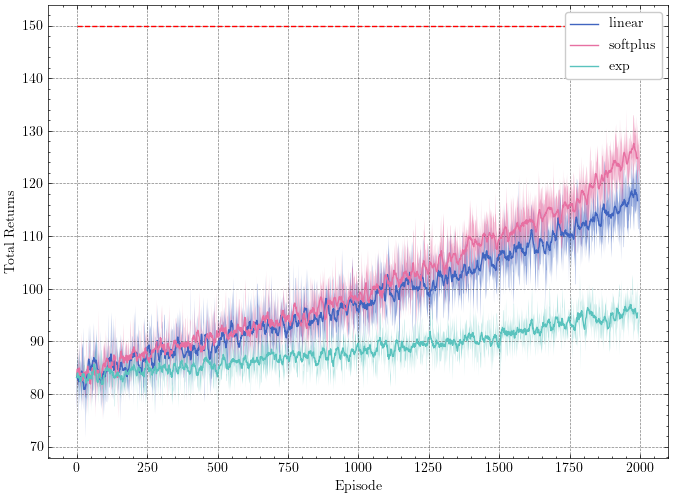

In [158]:
p_runner = ParallelRunner(4, params, legend_labels)
p_runner.run()
p_runner.plot_av_rewards(window=10, file_name='parameterisation')

## Investigating of Adaptive Gradients

### Dirichlet Unstable as it Approaches a Deterministic Policy 

By lowering $\gamma$ we were able to reduce the effect of confounding actions which improved learning especially early on whilst the Dirichlet distribution is uniform on the simplex. Considering other parameterisations also enabled us to improve the rate of learning. However, the learned policy is still far optimal. Although the graphs seem to show learning is still taking place, training has intentionally been halted early due to inherent instabilities in the algorithm as the solution approaches optimal.

In [570]:
params_1 = {
    'n_assets': 3,
    'α': 2.2e-4,
    'α_end': 2.2e-4,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': None,
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 4000
}

legend_labels = {
    '0': r'softplus'
}

params = [params_1]

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 11.58it/s]
1it [02:12, 132.13s/it]


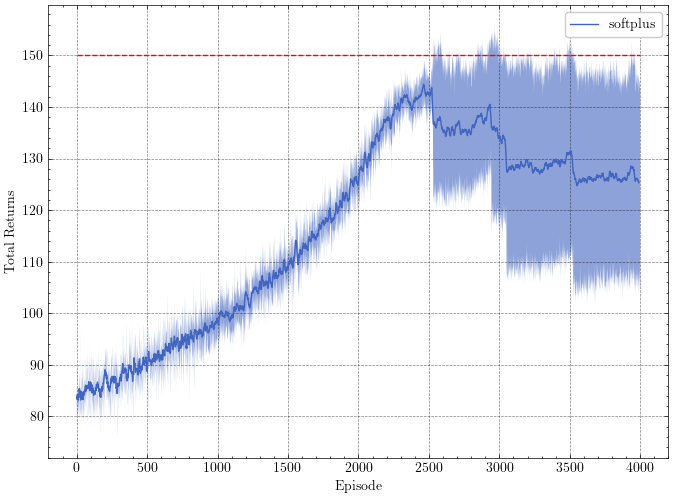

In [571]:
p_runner = ParallelRunner(10, params, legend_labels)
p_runner.run()
p_runner.plot_av_rewards(window=10)

To understand where this instability comes from it is instructive to plot the digamma and trigamma functions, where the trigamma function is defined as.

\begin{equation}
    \psi_1(x) = \frac{d^2}{d x^2} \ln \Gamma (x)
\end{equation}

In [155]:
nums = np.linspace(-0.5, 10, 1000)
da = digamma(nums)
pa = polygamma(1, nums)

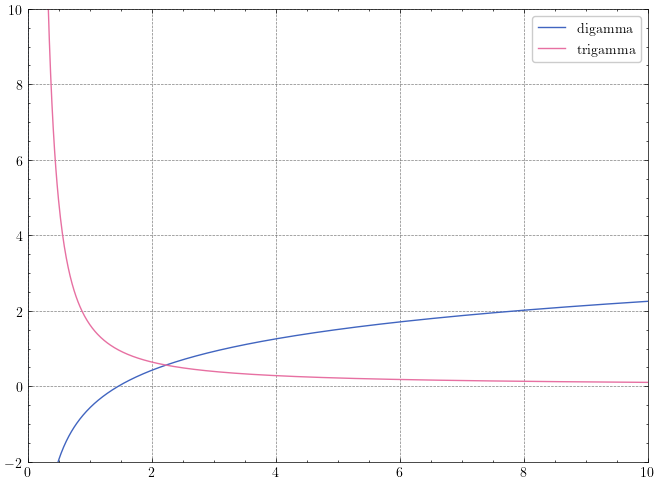

In [156]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(nums, da, label='digamma')
plt.plot(nums, pa, label='trigamma')
plt.ylim([-2, 10])
plt.xlim([0, 10])
plt.legend()
plt.savefig('./report_images/digamma-trigamma')

We see as the gradients of the policy explode as the policy become deterministic. When optimising for returns this is problematic as the optimal policy is highly concentrated on a single asset. We now try a heuristic by scaling the gradients by some combination of the maximum digamma/trigamma for the policy.

In [211]:
params_1 = {
    'n_assets': 3,
    'α': 9e-4,
    'α_end': 9e-4,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': 'max_digamma',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 2000
}

params_2 = {
    'n_assets': 3,
    'α': 1e-2,
    'α_end': 1e-2,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': 'max_polygamma',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 2000
}

params_3 = {
    'n_assets': 3,
    'α': 9e-3,
    'α_end': 9e-3,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': 'max_di_polly_interpolation',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 2000
}


legend_labels = {
    '0': r'digamma', 
    '1': r'polygamma',
    '2': r'interpolation',
}


params = [params_1, params_2, params_3]

0it [00:00, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 2023.55it/s]
1it [00:25, 25.76s/it]
100%|██████████| 4/4 [00:00<00:00, 2861.54it/s]
2it [00:53, 26.48s/it]
100%|██████████| 4/4 [00:00<00:00, 3053.18it/s]
3it [01:20, 26.91s/it]


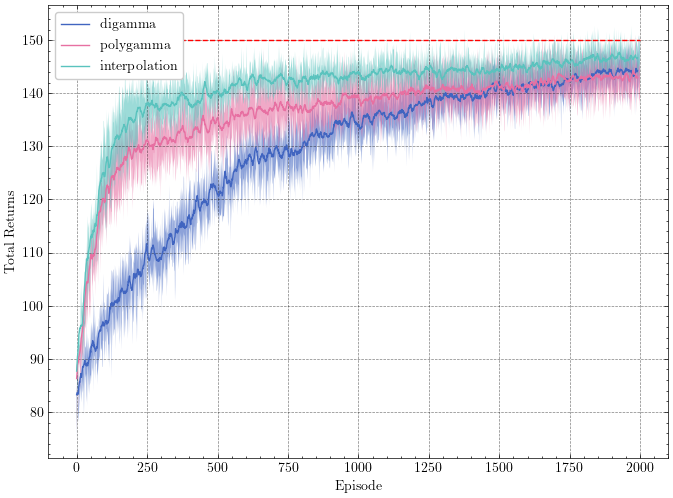

In [212]:
p_runner = ParallelRunner(4, params, legend_labels)
p_runner.run()
p_runner.plot_av_rewards(window=10, file_name='heuristic_grad_adapt')

## Investigating the Effect of Baseline and Noise Whittening.

In [224]:
params_1 = {
    'n_assets': 3,
    'α': 9e-2,
    'α_end': 9e-2,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': 'max_di_polly_interpolation',
    'returns_adpt_mode': 'both',
    'parameterisation': 'softplus',
    'eps': 2000
}


params_2 = {
    'n_assets': 3,
    'α': 5e-2,
    'α_end': 5e-2,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': 'max_di_polly_interpolation',
    'returns_adpt_mode': 'avg_r_baseline',
    'parameterisation': 'softplus',
    'eps': 2000
}



params_3 = {
    'n_assets': 3,
    'α': 8e-3,
    'α_end': 8e-3,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': 'max_di_polly_interpolation',
    'returns_adpt_mode': 'noise_whitening',
    'parameterisation': 'softplus',
    'eps': 2000
}


legend_labels = {'0': 'both', '1': 'avg. rewards', '2': 'noise whitening'}


params = [params_1, params_2, params_3]

0it [00:00, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 1920.47it/s]
1it [00:37, 37.98s/it]
100%|██████████| 4/4 [00:00<00:00, 3979.42it/s]
2it [01:09, 36.10s/it]
100%|██████████| 4/4 [00:00<00:00, 2996.47it/s]
3it [01:44, 34.81s/it]


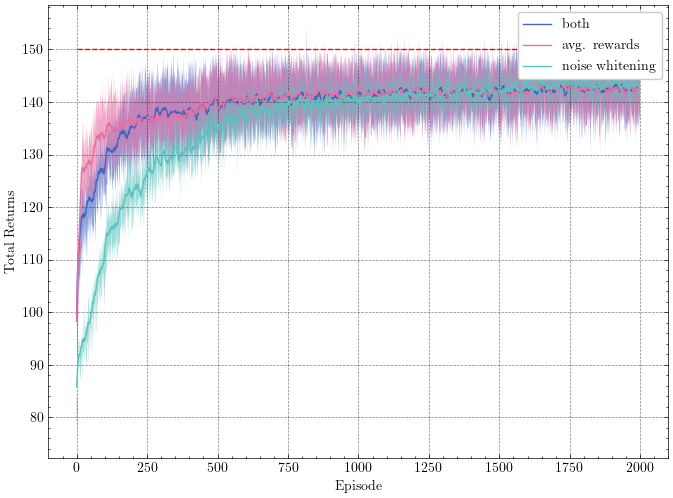

In [225]:
p_runner = ParallelRunner(4, params, legend_labels)
p_runner.run()
p_runner.plot_av_rewards(window=10, file_name='baseline_test')

## Visualising the Dirichlet Distribution

It can also be interesting to plot the probability simplex for a policy at different timesteps showing how the policy becomes more concentrated.

In [177]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

In [178]:
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))
def xy2bc(xy, tol=1.e-4):
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

In [179]:
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

In [200]:
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

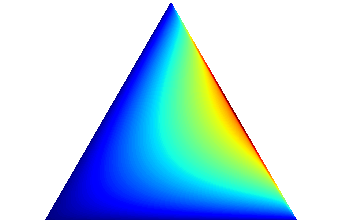

In [209]:
draw_pdf_contours(Dirichlet([0.94799552, 1.6613869 , 1.65199158]))

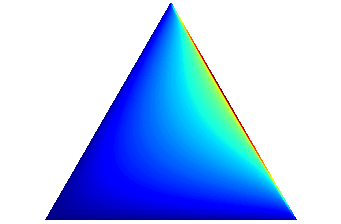

In [217]:
draw_pdf_contours(Dirichlet([0.8839873, 1.4676767, 1.6673427]))

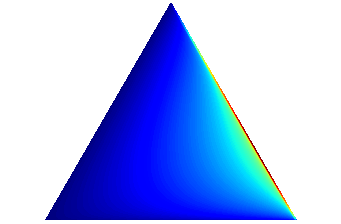

In [211]:
draw_pdf_contours(Dirichlet([0.86395913, 1.91488339, 1.39645818]))

# Natural Gradients

Previously we tried a heuristic fix to ameliorate the problem of exploading gradients that occur when any of the concentration parameters approched 0. We saw that the digamma function dominates the expression for the gradient as our policy became deterministic. We then experimented by normalising by the interpolation of the absolute value of the maximum digamma and trigamma vectors. This did stabalise learning however the method was naive and indiscriminantly squashed all gradient directions by the same amount. We will now take a look at natural gradient methods as a way to adapt the gradient such that it points in the steepest direction in the distribution space as supposed to the parameter space.

## Fisher Information 

For a parametric model, $p(x|\theta)$ it is common to deffine the following score function.

$$s(\theta) = \nabla_{\theta} \log{p(x|\theta)}$$

We might ask how confident we are in our estimate and for this we simply look at the covariance of the score function

$$\mathbb{E}_{p(x|\theta)}[(s(\theta) - 0)(s(\theta) -0)^{T}]$$

This is the definition of the Fisher information matrix

$$ \mathbf{F} = \mathbb{E}_{p(x|\theta)}[ \nabla_{\theta} \log{p(x|\theta)}\nabla_{\theta} \log{p(x|\theta)}^{T}]$$

We will look at how the Fisher information matrix can be used to adapt gradients taken in parameter space but first we will look at how $\mathbf{F}$ relates to the Hessian, $\mathbf{H}$.

## The Hessian and its Relation to Fisher Information

The Hessian is the matrix of second derivitives, a somewhat unintuitive relationship exists that 

$$\mathbf{F}_{i,j} = - \mathbb{E}_{p(x|\theta)} \left[ \frac{\partial }{\partial \theta_{i} \partial \theta{j}} \log{p(x|\theta)} \right] $$

or in terms of the entire matrix of second derivitives 

$$\mathbf{F} = - \mathbb{E}_{p(x|\theta)} \left[ \mathbf{H}_{\log{p(x|\theta)}} \right] $$

To see whay this is the case lets start by looking at the $i^{th}$, $j^{th}$ element

$$\frac{\partial }{\partial \theta_{i} \partial \theta{j}} \log{p(x|\theta)} 
= \nabla_{\theta_{i}} \left( \frac{\partial{\theta_{j}}  p(x|\theta) }{ p(x|\theta)} \right) 
=  \frac{\partial{\theta_{i,j}}  p(x|\theta) }{ p(x|\theta)} - \frac{\partial{\theta_{i}}  p(x|\theta) }{ p(x|\theta)}\frac{\partial{\theta_{j}}  p(x|\theta) }{ p(x|\theta)}
$$

taking expectations 

$$\mathbb{E} \left[\frac{\partial }{\partial \theta_{i} \partial \theta{j}} \log{p(x|\theta)} \right]
= \mathbb{E} \left[ \frac{\partial{\theta_{i,j}}  p(x|\theta) }{ p(x|\theta)} - \frac{\partial{\theta_{i}}  p(x|\theta) }{ p(x|\theta)}\frac{\partial{\theta_{j}}  p(x|\theta) }{ p(x|\theta)} \right]
= \mathbb{E} \left[ \frac{\partial{\theta_{i,j}}  p(x|\theta) }{ p(x|\theta)}  \right]
- \mathbb{E} \left[\frac{\partial{\theta_{i}} p(x|\theta) }{ p(x|\theta)}\frac{\partial{\theta_{j}}  p(x|\theta) }{ p(x|\theta)} \right] =  - \mathbb{E} \left[\frac{\partial{\theta_{i}} p(x|\theta) }{ p(x|\theta)}\frac{\partial{\theta_{j}}  p(x|\theta) }{ p(x|\theta)} \right]
$$

generalising this to the full Fisher matrix and Hessian we have

$$\mathbf{F} = - \mathbb{E}_{p(x|\theta)} [\mathbf{H}_{\log{p(x|\theta)}}] $$

This will have practical implications when we come to implementing the natural gradient. 


 
## Distribution Space

The gradient $\nabla s(\theta)$ can be interpreted as the steepest ascent direction for $s$. That means that per unit change in $\theta$ (where the change is measured with the standard Euclidean norm $||\cdot||$) we achive the gratest instantanious change in $s$. Formally we have 

$$\frac{\nabla s(\theta)}{|\nabla s(\theta)|} = \lim_{\epsilon \rightarrow 0} \frac{1}{\epsilon} \arg\max_{d: ||d|| \leq \epsilon} s(\theta + d)$$

The interesting thing to notice is that this depends on the Euclidian norm, we look at the Euclidian neighbourhood of $\theta$ without considering the local curvature of the distribution. To see why only considering the Euclidean geometry of the parameter space may be problematic consider the following two Gaussians, the shift in means is the same, but the change in representability of the two distributions (as measured by the KL divergence between the two distributions) is not.

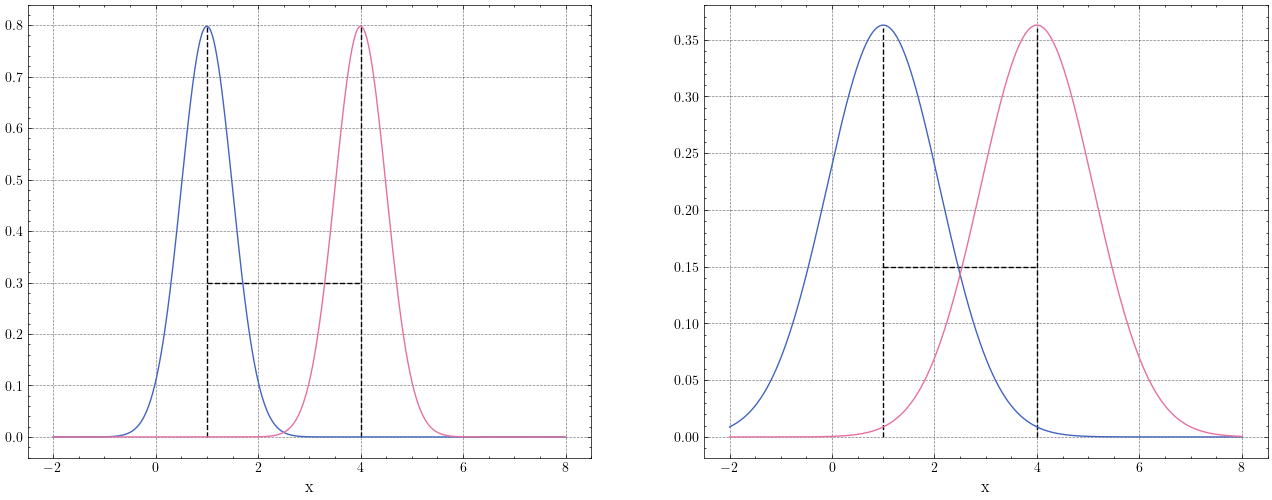

In [31]:
plt.figure(figsize=(16, 6), dpi=100)
a =  2
b = 2
x = np.linspace(-2, 8, 1000)
y1 = norm.pdf(x, 1, 0.5)
y2 = norm.pdf(x, 4, 0.5)



plt.subplot(1, 2, 1)
plt.plot(x, y1)
plt.plot(x, y2)
plt.xlabel('x', size=12)
plt.vlines(1, 0, 0.8, colors='black',linestyles='dashed')
plt.vlines(4, 0, 0.8, colors='black',linestyles='dashed')
plt.hlines(0.3, 1, 4, colors='black',linestyles='dashed')



plt.subplot(1, 2, 2)

y1 = norm.pdf(x, 1, 1.1)
y2 = norm.pdf(x, 4, 1.1)

plt.plot(x, y1)
plt.plot(x, y2)
plt.xlabel('x', size=12)
plt.vlines(1, 0, 0.36, colors='black',linestyles='dashed')
plt.vlines(4, 0, 0.36, colors='black',linestyles='dashed')
plt.hlines(0.15, 1, 4, colors='black',linestyles='dashed')

plt.savefig('./dist_space_example')

## Kullback–Leibler Divergence and its Relation to Fisher Information

An important fact is that the Fisher Information Matrix is the Hessian of the KL-divergence, which we shall prove.

$$KL[ p(x|\theta) ||  p(x|\theta^{'})] 
= \mathbb{E}_{ \log p(x|\theta)}[ \log p(x|\theta)] - \mathbb{E}_{\log p(x|\theta)}[\log p(x|\theta^{'})]$$

Taking the derivative wrt. $\theta^{'}$

$$\nabla_{\theta^{'}} KL[p(x|\theta) || p(x|\theta^{'})] 
= \nabla_{\theta^{'}}\mathbb{E}_{ p(x|\theta)}[\log p(x|\theta)] - \nabla_{\theta^{'}}\mathbb{E}_{ p(x|\theta)}[\log p(x|\theta^{'})]
= - \nabla_{\theta^{'}}\mathbb{E}_{p(x|\theta)}[\log p(x|\theta^{'})]
$$

The second derivative

$$\nabla_{\theta^{'}}^2 KL[ p(x|\theta) || p(x|\theta^{'})] 
= - \nabla_{\theta^{'}}^2\mathbb{E}_{p(x|\theta)}[\log p(x|\theta^{'})]
$$

thus we have 

$$\mathbf{H}_{KL[\log p(x|\theta) || \log p(x|\theta^{'})] } 
= - \int p(x|\theta) \nabla_{\theta^{'}}^2 \log p(x|\theta^{'}) |_{\theta^{'} = \theta} dx
= - \mathbb{E}_{p(x|\theta)}[\mathbf{H}_{log(x|\theta)}]
$$

which we just showed was equal to the Fisher Information Matrix.

## The Natural Gradient

We are now ready to derive the steepest direction in parameter space. Firstly, we take a second-order Taylor expansion of our metric

$$KL[p(x|\theta) || p(x|\theta+d)] \approx KL[p(x|\theta) | p(x|\theta)] + (\nabla KL[p(x|\theta) || p(x|\theta + d)])^T d + \frac{1}{2}d^T F d  $$

the first two terms are zero hence we have 

$$KL[p(x|\theta) || p(x|\theta+d)] \approx  \frac{1}{2}d^T F d  $$

next, we will find the vector d that maximises the score function in the distribution space, because our metric is KL-divergence this will be the direction the decreases the KL-divergence the most hence

$$d^{*} = \arg \max s(\theta + d) \text{ } \text{ s.t }  KL[p_{\theta} || p_{\theta+d}] = c$$




by fixing KL to some constant it ensures parameterisation invariance. We now have an optimisation problem which we can write in the Lagrangian form

$$d^{*} = \arg\max_{d} s(\theta + d) + \lambda (KL[p_{\theta} || p_{\theta+d}] - c)
\approx  \arg\max_{d} s(\theta) + \nabla_{\theta} s(\theta)^T d + \frac{1}{2}\lambda d^T \mathbf{F} d - \lambda c
$$

Taking derivatives and setting equal to zero we have

$$ d = - \frac{1}{\lambda} \mathbf{F}^{-1} \nabla_{\theta} s(\theta)$$

the Lagrangian factor can be absorbed into the learning rate, thus we have that the natural gradient  is given by

$$\tilde{\nabla}_{\theta} s(\theta) \propto \mathbf{F}^{-1} \nabla_{\theta} s(\theta)$$

## The Natural Gradient for the Dirichlet Distribution

We now calculate the Fisher Information Matrix of the Dirichlet Distribution. Taking the first derivative of the logarithm of the Dirichlet distribution we have 


$$ \frac{\partial}{\partial a_i} Dir(\mathbf{a})
= \psi \left( \mathbf{a}^T \mathbf{I} \right) -  \psi (a_i) + \ln w_i
$$

now taking second derivatives we have 

$$
 \frac{\partial^2}{\partial a_i a_j}Dir(\mathbf{a})  = \begin{cases} 
      \psi_1 \left( \mathbf{a}^T \mathbf{I} \right) -  \psi (a_i)   & \text{ if } i=j \\
       \psi_1 \left( \mathbf{a}^T \mathbf{I} \right)    0 & \text{ if } i\neq j \\
   \end{cases}
$$

where 

$$\psi_1(x) = \frac{d^2}{d x^2} \ln \Gamma (x)$$


this allows us to write the Hessian of the Dirichlet distribution and negating it results in the Fisher information matrix. Explicitly for a Dirichlet distribution defined on the 2D simplex, the Fisher Information Matrix is given by 

$$
\mathbf{F}_{Dir(\mathbf{a})} 
= \begin{bmatrix}
 \psi_1 (a_1) - \psi_1 \left( \mathbf{a}^T \mathbf{I} \right)  & - \psi_1 \left( \mathbf{a}^T \mathbf{I} \right) & - \psi_1 \left( \mathbf{a}^T \mathbf{I} \right)\\
- \psi_1 \left( \mathbf{a}^T \mathbf{I} \right) &  \psi_1 (a_2) - \psi_1 \left( \mathbf{a}^T \mathbf{I} \right)    & - \psi_1 \left( \mathbf{a}^T \mathbf{I} \right) \\
- \psi_1 \left( \mathbf{a}^T \mathbf{I} \right) & - \psi_1 \left( \mathbf{a}^T \mathbf{I} \right) &  \psi (a_3) - \psi_1 \left( \mathbf{a}^T \mathbf{I} \right) 
\end{bmatrix}
$$

In [44]:
params_1 = {
    'n_assets': 3,
    'α': 9e-3,
    'α_end': 9e-3,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.6,
    'grad_adpt_mode': 'max_di_polly_interpolation',
    'returns_adpt_mode': 'avg_r_baseline',
    'parameterisation': 'softplus',
    'eps': 2000
}

params_2 = {
    'n_assets': 3,
    'α':8e-2,
    'α_end': 8e-5,
    'start_ep': 500, 
    'α_decay_steps': 1000,
    'γ': 0.6,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': 'both',
    'parameterisation': 'softplus',
    'eps': 2000
}


legend_labels = {'0': 'interpolation', '1': 'natural gradients'}

params = [params_1, params_2]

In [45]:
p_runner = ParallelRunner(10, params, legend_labels)
p_runner.run()

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 45.32it/s]
1it [01:17, 77.35s/it]
100%|██████████| 10/10 [00:00<00:00, 3787.87it/s]
2it [02:38, 79.19s/it]


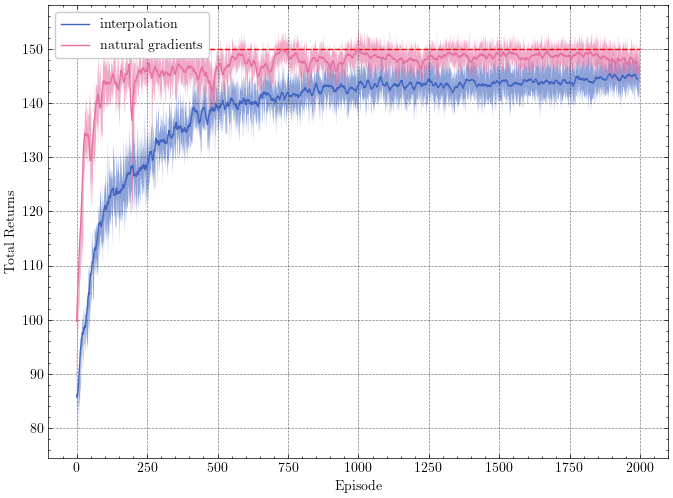

In [47]:
p_runner.plot_av_rewards(window=10)
plt.savefig('./simple_dir_ng')

In [292]:
plt.figure(figsize=(8, 6), dpi=100)

max_interpolation = np.max(p_runner.results['0'][0]['a_ns'], axis=1)
min_interpolation = np.min(p_runner.results['0'][0]['a_ns'], axis=1)
max_ng = np.max(p_runner.results['1'][0]['a_ns'], axis=1)
min_ng = np.min(p_runner.results['1'][0]['a_ns'], axis=1)

plt.plot(np.arange(2000), max_interpolation, label='max interpolation')
plt.plot(np.arange(2000), min_interpolation,  label='min interpolation')
plt.plot(np.arange(2000), max_ng, label='max ng')
plt.plot(np.arange(2000), min_ng, label='min ng')
plt.legend()

IndexError: list index out of range

<Figure size 800x600 with 0 Axes>

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 28.82it/s]
1it [01:15, 75.73s/it]
100%|██████████| 10/10 [00:00<00:00, 5854.70it/s]
2it [02:45, 82.52s/it]


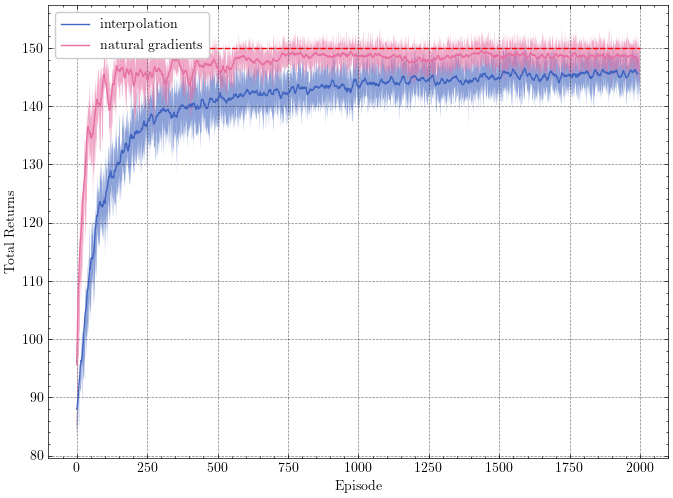

In [248]:
p_runner = ParallelRunner(10, params, legend_labels)
p_runner.run()
p_runner.plot_av_rewards(window=10, file_name='natural_gradients')

# Measuring the KL Divergence Between Successive Dirichlet Policies

It is instructive to check that the KL-divergence between subsequent policies shrinks during training.

$$
Dir(w | \mathbf{a}) = \frac{\Gamma(\mathbf{a}^T \mathbf{I})}{\prod_{n=1}^N \Gamma(a_n)} \prod_{n=1}^N w_n^{\alpha_N-1}
$$

$$
KL(p||q) = \int p(x) \log \frac{p(x)}{q(x)} dx = \left < \log \frac{p(x)}{q(x)}  \right>_{p(x)}
$$

$$
KL(Dir(w | \mathbf{a}) || Dir(w | \mathbf{b}) )
= \left < 
\log \Gamma(\mathbf{a}^T \mathbf{I}) - \sum_{n=1}^N \log \Gamma(a_n) + \sum (a_n-1) \log w_n 
- 
\log \Gamma(\mathbf{b}^T \mathbf{I}) - \sum_{n=1}^N \log \Gamma(b_n) + \sum (b_n-1) \log w_n
\right >_{Dir(w | \mathbf{a})}
$$



$$
=
\log \Gamma(\mathbf{a}^T \mathbf{I}) - \sum_{n=1}^N \log \Gamma(a_n) + 
- 
\log \Gamma(\mathbf{b}^T \mathbf{I}) + \sum_{n=1}^N \log \Gamma(b_n) + 
\sum_{n}^{N} (a_n - b_n) \left < \log w_k \right >_{Dir(w | \mathbf{a})}
$$


$$\left < \log w_n \right>_{Dir(w | \mathbf{a})} = \psi(a_n) - \psi(\mathbf{a}^T \mathbf{I})$$

thus the KL-divergence between two Dirichlet distributions is given by

$$
KL(Dir(w | \mathbf{a}) || Dir(w | \mathbf{b}) )  
= \log \Gamma(\mathbf{a}^T \mathbf{I}) - \sum_{n=1}^N \log \Gamma(a_n) 
- 
\log \Gamma(\mathbf{b}^T \mathbf{I}) + \sum_{n=1}^N \log \Gamma(b_n) + \sum_{n=1}^N (a_n –  b_n) (\psi(a_n)-\psi(\mathbf{a}^T \mathbf{I}))
$$

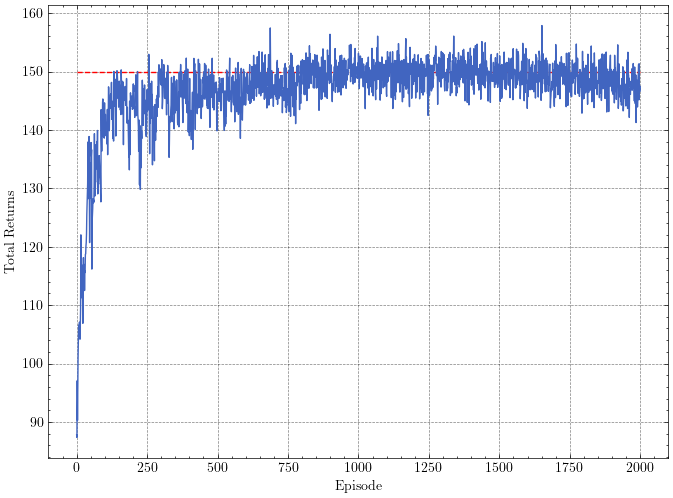

In [24]:
env = GenerativeMarketEnv([1, 3, 1], [[.1, 0, 0], [0, .1, 0], [0, 0, .1] ])
policy = DirichletPolicy(
    3,  α=6e-2, α_end=8e-4, start_ep=300, 
        α_decay_steps=1000, γ=0.6,
    grad_adpt_mode='natural_gradient', returns_adpt_mode='both',
    parameterisation='softplus'
)
harness = Harness(env, policy)
eps = 2000
harness.train(num_episodes=eps)
harness.plot_smooth_rewards(eps, window=1)

In [25]:
def calc_kl_div(αs, βs):
    α0 = np.sum(αs)
    β0 = np.sum(βs)
    
    α_sum = np.log(gamma(α0)) - np.sum(gammaln(αs))
    
    β_sum = - np.log(gamma(β0)) + np.sum(gammaln(βs))
    
    geometric_mean = (np.array(αs)  - np.array(βs))@(digamma(αs) - digamma(np.sum(αs)))

    return α_sum + β_sum + geometric_mean

In [26]:
as_start = np.array(harness.hist['a_ns'])[:-1]

as_end = np.array(harness.hist['a_ns'])[1:]

In [27]:
kl_div = []
for t, tp1 in zip(as_start, as_end):
    kl_div.append(calc_kl_div(t, tp1))

['KL', 'a2']


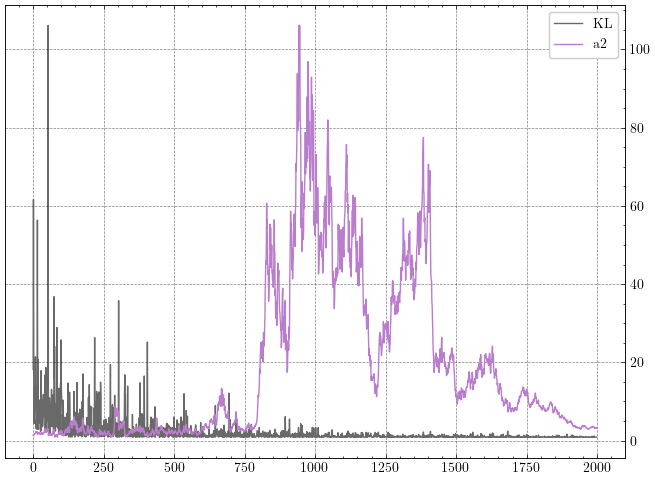

In [33]:
fig, ax_left = plt.subplots(figsize=(8, 6), dpi=100)
ax_right = ax_left.twinx()



a2 = np.array(harness.hist['a_ns'])[:,1]

# ax_left.plot(np.arange(3999), kl_div, label='KL', color='#5ac3be')
lns1 = ax_left.plot(np.arange(1999), kl_div, label='KL', color='#696969')

# Hide axes ticks

ax_left.set_yticks([])
lns2 = ax_right.plot(np.arange(2000), a2, label='a2', linestyle='-', color='#ba7dcd')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs)
print(labs)

# ax_left.legend()
# ax_right.legend()

plt.savefig('./report_images/kl_div')

It is satisfying to see that although in parameter space large fluctuations in the second concentration parameter appear, in the probability space these fluctuations are not significant.